In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as  pd
import os
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE
import umap
%matplotlib inline

Overview:

Use the same dataset you've used during this module. It would be nice if you save the result from the data preparation step and use it in the current task.

The main goal here is to use different dimensionality reduction techniques and show results

Evaluation criteria (10 max):

 - at least 3 different dimensionality reductions techniques (SVD, t-SNE, PCA, NMF, UMAP) used - 4 points
 - add visualizations for 3 different dimensionality reductions techniques - 3 points
 - calculate explained variance for 2 different dimensionality reductions techniques - 1 points
 - select the best number of components for at least 1 dimensionality reduction technique - 2 point

# Working with dataset

## Read data

Here we read data that was earlier processed via pipeline notebook and saved in the root of our Google Drive. In case you saved it somewhere else, fix the paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root_path = '/content/drive/My Drive'

In [ ]:
df = pd.read_csv(os.path.join(data_root_path, "preprocessed_full.csv.gz"))

In [ ]:
df.head().T

,0,1,2,3,4
0,1.371657,1.509656,-0.111890,0.138444,1.371657
1,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
2,0.778225,0.778225,0.177827,0.778225,0.177827
3,-0.003764,0.768075,0.768075,0.768075,0.768075
4,0.526417,-0.324254,0.138444,-0.309743,0.702315
...,...,...,...,...,...
69,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000
71,1.000000,1.000000,1.000000,1.000000,1.000000
72,0.000000,0.000000,0.000000,0.000000,0.000000


## Split on X-y

We need to separate X and y because later we are going to transform our features and use data from y as labels during visualizations

In [ ]:
target = ['target']

In [ ]:
X = df[df.columns.difference(target)]
y = df[target]

# Dimensionality reduction

As soon as our data is already preprocessed and normalized we already can start with dimensionality reduction. Normally we should use basic preprocessing (converting categorical data, standard scaling for example).

For each different method we will follow similar pipeline - 

1.   transform current dataset
2.   visualize results
3.   calculate explained variance (if possible)
4.   evaluate number of componenents to exceeed explained variance threshold (if possible)



# Linear transformations

## PCA

### transforming

In [ ]:
pca = PCA(n_components=2,svd_solver="randomized")
new_X = pca.fit_transform(X)

### visualize results

In [ ]:
plot_df = pd.DataFrame.from_records(data=new_X[:,:2],columns=["x","y"])
plot_df["target"] = y

In [ ]:
plot_df

,x,y,target
0,1.302062,-3.417340,0
1,1.094785,-3.418747,0
2,2.081544,-2.742037,0
3,1.128088,-3.411799,0
4,3.292379,-2.604159,0
...,...,...,...
41183,3.874982,-2.444417,1
41184,4.269648,-2.885121,0
41185,3.486073,2.368316,0
41186,4.369262,-2.844671,1


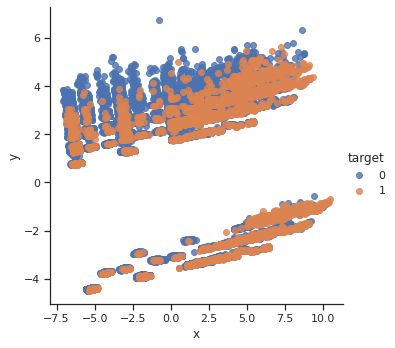

In [ ]:
sns.set(style="ticks")
sns.lmplot("x","y",data=plot_df,hue="target",fit_reg=False)

### explained variance

In [ ]:
pca.explained_variance_ratio_.sum()

0.48069340823363754

Value 0.48 is quite ok in common situation, but sometimes we want to achieve much higher performance.

### number of compomemets

In case we need to achieve certain level of explained variance we may pass it as a parameter to our PCA model. Let's select threshold value equal to 0.95 and look how much components we need in our case.

In [ ]:
pca = PCA(n_components=0.95).fit(X)

len(pca.explained_variance_ratio_)

22

Now we want to plot how explained variance changed with number of components we used in our PCA

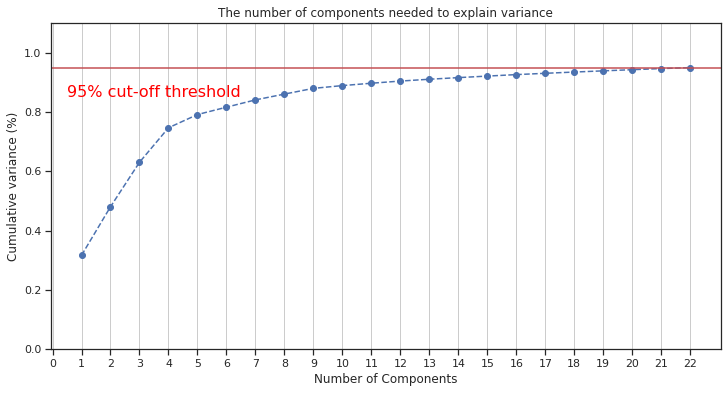

In [ ]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## SVD

### transforming

In [ ]:
svd = TruncatedSVD()
svd_X = svd.fit_transform(X)

### visualize results

In [ ]:
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = y

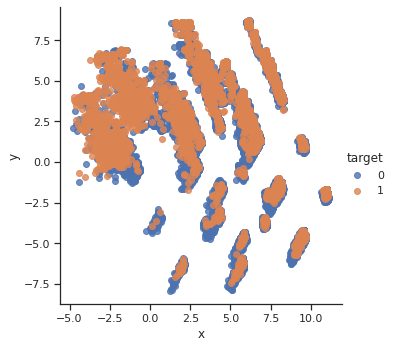

In [ ]:
sns.set(style="ticks")
sns.lmplot("x","y",data=plot_df,hue="target",fit_reg=False)

### explained variance

In [ ]:
svd.explained_variance_ratio_.sum()

0.4599023351309931

### number of components

In case with SVD we can't pass explained variance as a parameter. To find number of componenets to achieve expected level of variance we may generate maximum available number of components and iterate over list of explained variances and find first value

In [ ]:
svd = TruncatedSVD(n_components=X.shape[1]-1).fit(X)

len(svd.explained_variance_ratio_)

72

Now we want to plot how explained variance changed with number of components we used in our PCA

In [ ]:
def select_n_components(var_ratios, goal_var: float) -> int:
  total_variance = 0.0
  n_components = 0
  
  for explained_variance in var_ratios:
    total_variance += explained_variance
    n_components += 1

    if total_variance >= goal_var:
        break
          
  return n_components

In [ ]:
expected_number_of_components = select_n_components(svd.explained_variance_ratio_, 0.95)
expected_number_of_components

23

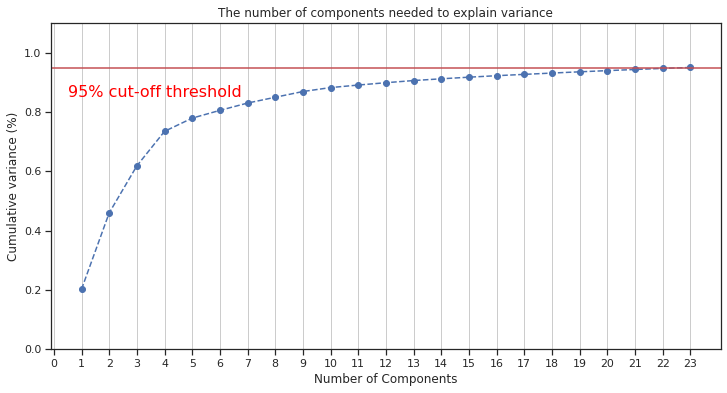

In [ ]:
number_of_ticks = expected_number_of_components + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(svd.explained_variance_ratio_[:expected_number_of_components])

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## NMF

### transforming

We need to remove negative values to run sklearn NMF

In [ ]:
X.values.min()

-5.199337582605575

In [ ]:
X_non_negative = X + -1*(X.values.min())
(X_non_negative < 0).any().sum()

0

In [ ]:
nmf = NMF(n_components=2)
nmf_X = nmf.fit_transform(X_non_negative)

### visualize results

In [ ]:
plot_df = pd.DataFrame.from_records(data=nmf_X[:,:2],columns=["x","y"])
plot_df["target"] = y

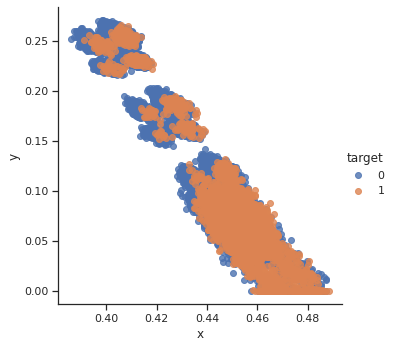

In [ ]:
sns.set(style="ticks")
sns.lmplot("x","y",data=plot_df,hue="target",fit_reg=False)

# Use non-linear transformation

## UMAP

### transforming

In [ ]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,metric='cosine').fit_transform(X)

### visualize results

In [ ]:
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = y

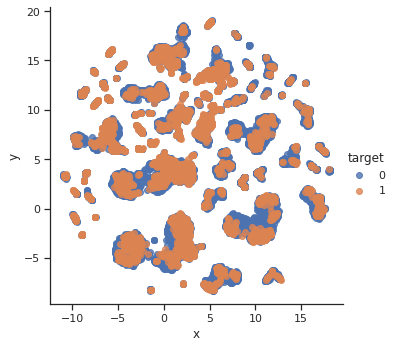

In [ ]:
sns.set(style="ticks")
sns.lmplot("x","y",data=plot_df,hue="target",fit_reg=False)

## t-SNE

### transforming

In [ ]:
tsne = TSNE(n_components=2)
tsne_X = tsne.fit_transform(X)

### visualize results

In [ ]:
plot_df = pd.DataFrame.from_records(data=tsne_X,columns=["x","y"])
plot_df["target"] = y

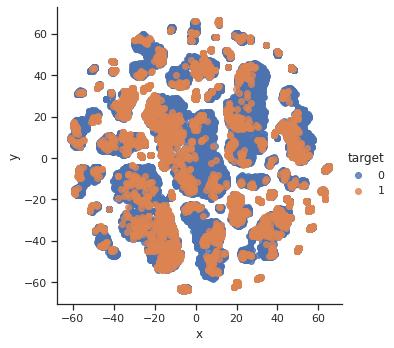

In [ ]:
sns.set(style="ticks")
sns.lmplot("x","y",data=plot_df,hue="target",fit_reg=False)

# Summary

Here we used different dimensionality reduction techniques. As a common result we may look at different visualizations. Also we may calculate explained variance as a numerical value of "quality" of linear dimensionality reduction methods. Some ideas of choosing number of components based on explained variance values provided.